# VIP 타겟 생성 코드

## 라이브러리 및 한글 폰트 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 모델링 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import LabelEncoder

# 한글 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic, Colab: NanumBarunGothic)
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False


## 타겟 생성 함수 정의

In [2]:

# ==========================================
# 1. 타겟 생성 함수 (Method B: 20% 감소 룰)
# ==========================================
def generate_target_method_b(file_path):
    print(f"[Info] 데이터 로드 및 타겟(Method B) 생성 시작")
    
    # 1. 데이터 로드
    try:
        # 실제 데이터 파일 경로로 수정 필요
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 파일 로드 실패: {e}")
        return None, None

    # 2. 전처리 (결측치 0 처리)
    cols_to_fill = ['이용금액_신용_B0M', '이용금액_체크_B0M', '이용금액_신용_R3M', '이용금액_체크_R3M']
    for c in cols_to_fill:
        if c in df.columns:
            df[c] = df[c].fillna(0)
        else:
            print(f"⚠️ 컬럼 누락(0처리): {c}")
            df[c] = 0
            
    # 3. 파생 변수 생성 (벡터 연산)
    # 당월 총 이용금액
    df['당월_총_이용금액'] = df['이용금액_신용_B0M'] + df['이용금액_체크_B0M']
    
    # 직전 3개월 평균 (R3M이 '3개월 합계'라고 가정하고 3으로 나눔)
    df['직전_3M_평균_이용금액'] = (df['이용금액_신용_R3M'] + df['이용금액_체크_R3M']) / 3
    
    # 4. 타겟 정의 (Vectorized)
    # 조건 1: 판단 제외 대상 (평균 0원 이하 - 아예 안 쓰던 사람)
    cond_exclude = (df['직전_3M_평균_이용금액'] <= 0)
    
    # 조건 2: 이탈 대상 (당월 < 평균의 80%)
    # 제외 대상이 아니면서, 감소폭이 큰 경우 (0.8 미만으로 떨어짐)
    cond_churn = (df['당월_총_이용금액'] < (df['직전_3M_평균_이용금액'] * 0.8))
    
    # Target 초기화 (NaN)
    df['Target'] = np.nan
    
    # 조건 적용
    # 이탈(1): 제외 대상이 아니고(AND) 이탈 조건 만족
    df.loc[~cond_exclude & cond_churn, 'Target'] = 1
    
    # 유지(0): 제외 대상이 아니고(AND) 이탈 조건 불만족
    df.loc[~cond_exclude & ~cond_churn, 'Target'] = 0
    
    # 5. 데이터 분리
    # 타겟이 생성된 데이터만 학습에 사용 (NaN인 휴면/신규 추정 고객은 제외)
    train_df = df[df['Target'].notna()].copy()
    train_df['Target'] = train_df['Target'].astype(int)
    
    dormant_df = df[df['Target'].isna()].copy()
    
    print("\n" + "="*40)
    print("📊 타겟 생성 결과 (Method B: 20% 감소)")
    print("="*40)
    print(f" - 전체 데이터: {len(df)}건")
    print(f" - 학습용 데이터(0/1): {len(train_df)}건")
    print(f"   └ 이탈(1): {train_df['Target'].sum()}건 ({train_df['Target'].mean()*100:.2f}%)")
    print(f"   └ 유지(0): {len(train_df) - train_df['Target'].sum()}건")
    print(f" - 판단 제외(NaN): {len(dormant_df)}건")
    
    return train_df, dormant_df


In [3]:
FILE_PATH = '../260108/VIP/combined_part1.csv'
train_data, test_data = generate_target_method_b(FILE_PATH)

[Info] 데이터 로드 및 타겟(Method B) 생성 시작

📊 타겟 생성 결과 (Method B: 20% 감소)
 - 전체 데이터: 600000건
 - 학습용 데이터(0/1): 578272건
   └ 이탈(1): 46937건 (8.12%)
   └ 유지(0): 531335건
 - 판단 제외(NaN): 21728건


In [11]:
# 1. 데이터 로드 상태 자가진단
if 'train_data' not in locals() or train_data is None:
    print("❌ [진단 결과] 'train_data' 변수가 없거나 비어(None) 있습니다.")
    print("   >> 위쪽의 'generate_target_method_b' 코드를 다시 실행해서 데이터를 로드해주세요!")
else:
    print(f"✅ [진단 결과] 데이터 정상 로드됨 ({len(train_data)}행)")

✅ [진단 결과] 데이터 정상 로드됨 (578272행)


## 데이터 누수 방지 함수

In [12]:
# 2. 함수 재정의 (안전 장치 추가)
def get_clean_Xy_with_group_split(data, id_col='발급회원번호', target_col='Target', top_n=20):
    # [안전 장치 1] 데이터가 없으면 명시적으로 4개의 None을 반환하여 언패킹 에러 방지
    if data is None: 
        print("❌ [함수 내부] 입력 데이터(data)가 None입니다. 작업을 중단합니다.")
        return None, None, None, None
        
    print(f"\n⚡ [통합 프로세스] 누수 탐지 및 ID({id_col}) 기준 그룹 분할 시작")
    
    # [안전 장치 2] Target 컬럼 확인
    if target_col not in data.columns:
        print(f"❌ [함수 내부] 데이터에 '{target_col}' 컬럼이 없습니다. (이미 지워졌거나 컬럼명 오타)")
        return None, None, None, None

    # ---------------------------------------------------------
    # 1. 누수(Leakage) 의심 컬럼 탐지
    # ---------------------------------------------------------
    temp_excludes = [id_col, target_col, '당월_총_이용금액', '직전_3M_평균_이용금액', 
                     '이용금액_신용_B0M', '이용금액_체크_B0M', '이용금액_신용_R3M', '이용금액_체크_R3M']
    
    X_detect = data.drop(columns=[c for c in temp_excludes if c in data.columns])
    y_detect = data[target_col]
    
    for col in X_detect.select_dtypes(include=['object']).columns:
        X_detect[col] = LabelEncoder().fit_transform(X_detect[col].astype(str))
    
    lgbm = LGBMClassifier(n_estimators=50, random_state=42, verbose=-1)
    lgbm.fit(X_detect, y_detect)
    
    imp_df = pd.DataFrame({'feature': X_detect.columns, 'importance': lgbm.feature_importances_})
    top_features = imp_df.sort_values(by='importance', ascending=False).head(top_n)['feature'].tolist()
    
    print(f"   👉 감지된 누수 키워드: {top_features}")
    
    drop_keywords = temp_excludes + top_features
    final_drop_cols = []
    for col in data.columns:
        if any(keyword in col for keyword in drop_keywords):
            final_drop_cols.append(col)
            
    if id_col in final_drop_cols: final_drop_cols.remove(id_col)
    if target_col in final_drop_cols: final_drop_cols.remove(target_col)
    final_drop_cols = list(set(final_drop_cols))

    # ---------------------------------------------------------
    # 2. ID 기준 그룹 분할 (Group Split)
    # ---------------------------------------------------------
    unique_ids = data[[id_col, target_col]].drop_duplicates(subset=[id_col])
    
    train_ids, test_ids = train_test_split(
        unique_ids[id_col], 
        test_size=0.2, 
        random_state=42, 
        stratify=unique_ids[target_col]
    )
    
    train_df = data[data[id_col].isin(train_ids)].copy()
    test_df = data[data[id_col].isin(test_ids)].copy()
    
    # ---------------------------------------------------------
    # 3. 최종 X, y 분리 및 누수 컬럼 제거
    # ---------------------------------------------------------
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    
    cols_to_drop = final_drop_cols + [id_col, target_col]
    X_train = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns])
    X_test = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns])
    
    # 4. 전처리
    for col in X_train.select_dtypes(include=['object']).columns:
        try:
            le = LabelEncoder()
            full_cats = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)
            le.fit(full_cats)
            X_train[col] = le.transform(X_train[col].astype(str))
            X_test[col] = le.transform(X_test[col].astype(str))
        except:
            X_train = X_train.drop(columns=[col])
            X_test = X_test.drop(columns=[col])
            
    X_train = X_train.fillna(-999)
    X_test = X_test.fillna(-999)
    
    print(f"✅ 최종 완료: X_train {X_train.shape}, X_test {X_test.shape}")
    
    # [핵심] 이 부분이 빠지면 에러가 납니다!
    return X_train, X_test, y_train, y_test

In [ ]:
# [Step 1] 통합 함수 실행 (누수 제거 + ID 분할 + 전처리)
# id_col에 실제 고객식별번호 컬럼명을 정확히 적어주세요.
# ('발급회원번호', 'CUST_I# 함수가 None을 반환하더라도 에러가 나지 않도록 체크 로직 추가
result_tuple = get_clean_Xy_with_group_split(
    train_data, 
    id_col='발급회원번호', 
    top_n=20
)


⚡ [통합 프로세스] 누수 탐지 및 ID(발급회원번호) 기준 그룹 분할 시작
   👉 감지된 누수 키워드: ['이용금액_신판_B0M', '이용금액_신판_R3M', '이용금액_CA_R3M', '이용금액_할부_R3M', '이용금액_CA_B0M', '이용금액_일시불_B0M', '이용금액_일시불_R3M', '이용건수_체크_B0M', '이용금액_할부_B0M', '이용건수_체크_R3M', '변동률_잔액_B1M', '이용건수_CA_R3M', '이용금액_업종기준', '최종이용일자_기본', '이용금액_할부_무이자_B0M', '이용금액_체크_R12M', '증감율_이용금액_신용_전월', '변동률_일시불평잔', '이용금액_할부_무이자_R3M', '최종이용일자_신판']
✅ 최종 완료: X_train (462663, 865), X_test (115609, 865)


### 모델 학습

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    recall_score, roc_curve, f1_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def run_single_model(X_train, X_test, y_train, y_test, model_name='lgbm'):
    """
    모델 학습 후, 학습된 모델 객체와 성능 지표들을 딕셔너리 형태로 반환합니다.
    """
    
    # 1. 모델 이름 정규화
    model_name = model_name.lower()
    name_map = {'rf': 'RandomForest', 'xgb': 'XGBoost', 'lgbm': 'LightGBM'}
    
    if model_name not in name_map:
        print("❌ 모델명은 'rf', 'xgb', 'lgbm' 중 하나여야 합니다.")
        return None

    full_name = name_map[model_name]
    print(f"\n🔍 [{full_name}] 모델 학습 및 분석 시작...")

    # 2. 모델 정의 (Balanced Weight 적용)
    model = None
    
    if model_name == 'rf':
        model = RandomForestClassifier(
            n_estimators=100, 
            class_weight='balanced', 
            random_state=42, n_jobs=-1
        )
        
    elif model_name == 'lgbm':
        model = LGBMClassifier(
            n_estimators=100, 
            learning_rate=0.1, 
            class_weight='balanced', 
            random_state=42, verbose=-1
        )
        
    elif model_name == 'xgb':
        # XGBoost용 가중치 계산
        count_neg = (y_train == 0).sum()
        count_pos = (y_train == 1).sum()
        scale_weight = count_neg / count_pos
        
        model = XGBClassifier(
            n_estimators=100, 
            learning_rate=0.1, 
            max_depth=6,
            scale_pos_weight=scale_weight,
            eval_metric='logloss',
            random_state=42, 
            use_label_encoder=False
        )

    # 3. 학습
    print("⏳ 학습 중...")
    model.fit(X_train, y_train)
    
    # 4. 예측
    pred_label = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]

    # 5. 성능 지표 계산
    auc = roc_auc_score(y_test, pred_prob)
    recall = recall_score(y_test, pred_label)
    f1 = f1_score(y_test, pred_label)
    
    # 6. 상세 리포트 출력 (눈으로 확인용)
    print("="*60)
    print(f"📊 {full_name} 평가 리포트")
    print(f"   👉 AUC: {auc:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print("-" * 60)
    print(classification_report(y_test, pred_label, target_names=['유지', '이탈']))
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, pred_label), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{full_name} Confusion Matrix')
    plt.show()

    # Feature Importance (있으면 출력)
    if hasattr(model, 'feature_importances_'):
        imp = model.feature_importances_
        idx = np.argsort(imp)[::-1][:15]
        plt.figure(figsize=(8, 5))
        plt.barh(range(len(idx)), imp[idx], align='center')
        plt.yticks(range(len(idx)), [X_train.columns[i] for i in idx])
        plt.gca().invert_yaxis()
        plt.title(f'{full_name} Feature Importance Top 15')
        plt.show()

    # 7. 결과 반환 (나중에 비교를 위해 저장)
    result_dict = {
        'model_name': full_name,
        'model': model,
        'auc': auc,
        'recall': recall,
        'f1': f1,
        'y_pred': pred_label,
        'y_prob': pred_prob
    }
    
    return result_dict

#### lightGBM


🔍 [LightGBM] 모델 학습 및 분석 시작...
⏳ 학습 중...
📊 LightGBM 평가 리포트
   👉 AUC: 0.9690 | Recall: 0.9090 | F1: 0.5977
------------------------------------------------------------
              precision    recall  f1-score   support

          유지       0.99      0.90      0.94    106168
          이탈       0.45      0.91      0.60      9441

    accuracy                           0.90    115609
   macro avg       0.72      0.90      0.77    115609
weighted avg       0.95      0.90      0.91    115609



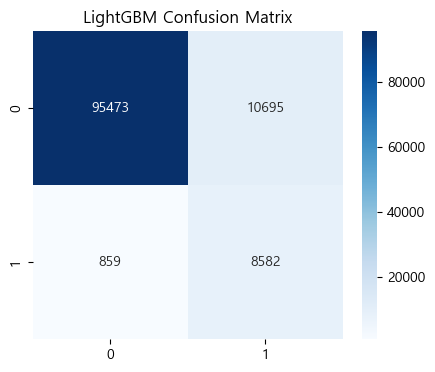

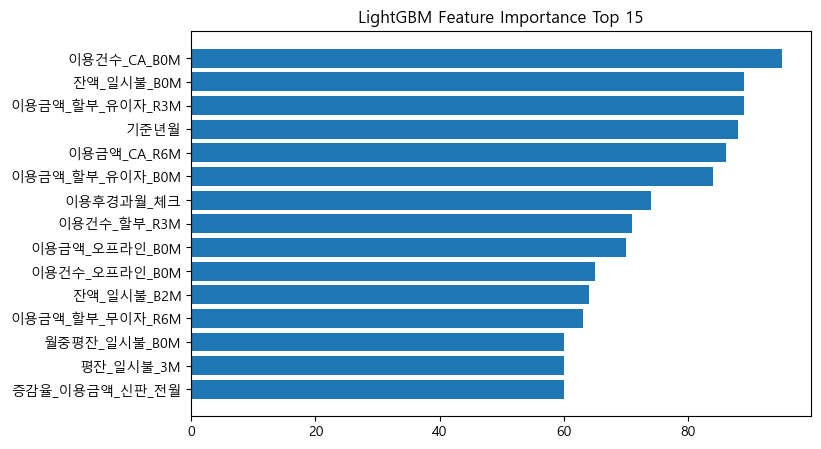

In [19]:
# 정상적으로 4개가 반환되었을 때만 언패킹
if result_tuple[0] is not None:
    X_train, X_test, y_train, y_test = result_tuple
    
    # 모델 실행
    res_lgbm = run_single_model(X_train, X_test, y_train, y_test, 'lgbm')
else:
    print("⚠️ 데이터 준비 실패로 모델링을 진행할 수 없습니다.")

#### RandomForest


🔍 [RandomForest] 모델 학습 및 분석 시작...
⏳ 학습 중...
📊 RandomForest 평가 리포트
   👉 AUC: 0.9488 | Recall: 0.3999 | F1: 0.5512
------------------------------------------------------------
              precision    recall  f1-score   support

          유지       0.95      1.00      0.97    106168
          이탈       0.89      0.40      0.55      9441

    accuracy                           0.95    115609
   macro avg       0.92      0.70      0.76    115609
weighted avg       0.94      0.95      0.94    115609



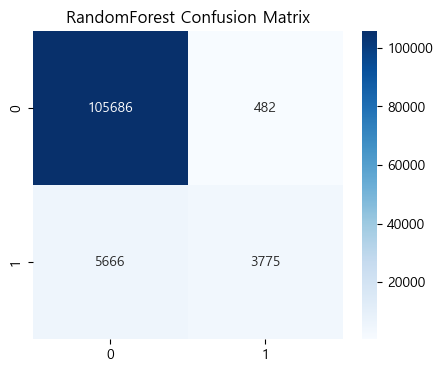

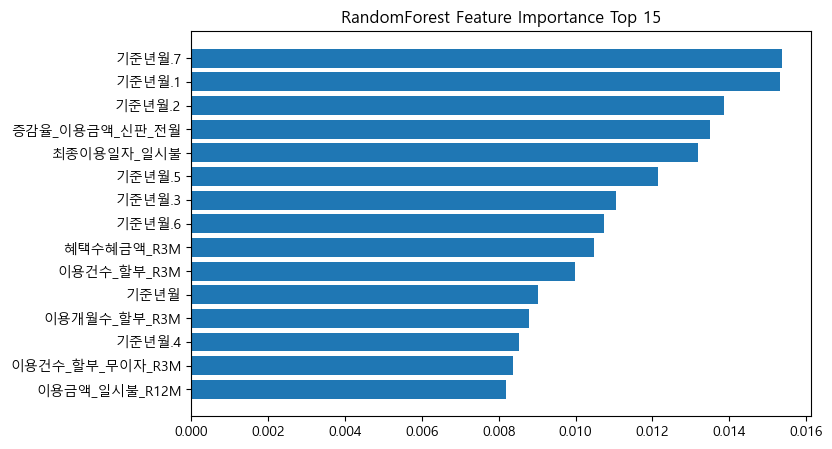

In [18]:
# 정상적으로 4개가 반환되었을 때만 언패킹
if result_tuple[0] is not None:
    X_train, X_test, y_train, y_test = result_tuple
    
    # 모델 실행
    res_rf = run_single_model(X_train, X_test, y_train, y_test, 'rf')
else:
    print("⚠️ 데이터 준비 실패로 모델링을 진행할 수 없습니다.")

#### XGBoost


🔍 [XGBoost] 모델 학습 및 분석 시작...
⏳ 학습 중...


c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:25:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 XGBoost 평가 리포트
   👉 AUC: 0.9676 | Recall: 0.9042 | F1: 0.5929
------------------------------------------------------------
              precision    recall  f1-score   support

          유지       0.99      0.90      0.94    106168
          이탈       0.44      0.90      0.59      9441

    accuracy                           0.90    115609
   macro avg       0.72      0.90      0.77    115609
weighted avg       0.95      0.90      0.91    115609



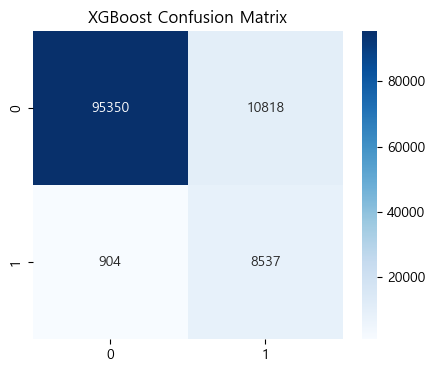

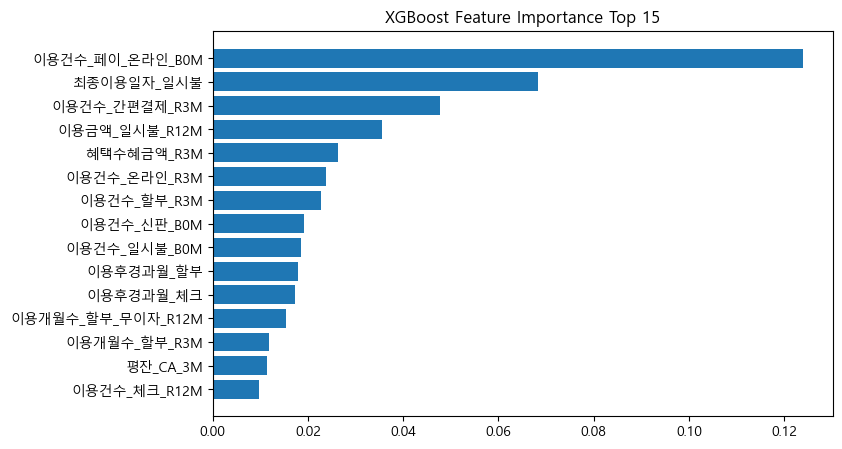

In [20]:
# 정상적으로 4개가 반환되었을 때만 언패킹
if result_tuple[0] is not None:
    X_train, X_test, y_train, y_test = result_tuple
    
    # 모델 실행
    res_xgb = run_single_model(X_train, X_test, y_train, y_test, 'xgb')
else:
    print("⚠️ 데이터 준비 실패로 모델링을 진행할 수 없습니다.")

### 모델 3개 시각화(lgbm, xgb, rf)


🏆 3대 모델 성능 비교표
              Recall (재현율)  Accuracy (정확도)  AUC Score  F1-Score
Model                                                          
LightGBM          0.909014        0.900060   0.969002  0.597674
RandomForest      0.399852        0.946821   0.948768  0.551175
XGBoost           0.904247        0.898607   0.967638  0.592930


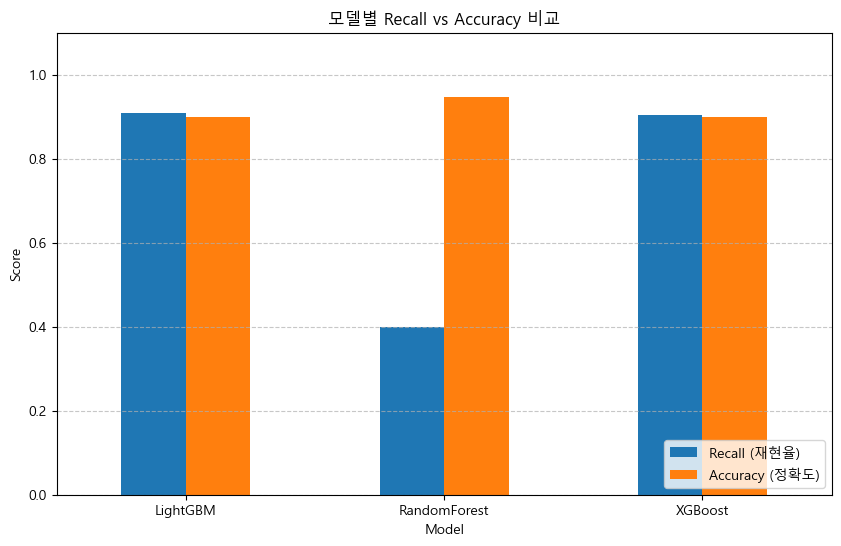


🔍 모델별 혼동행렬 (Confusion Matrix) 비교


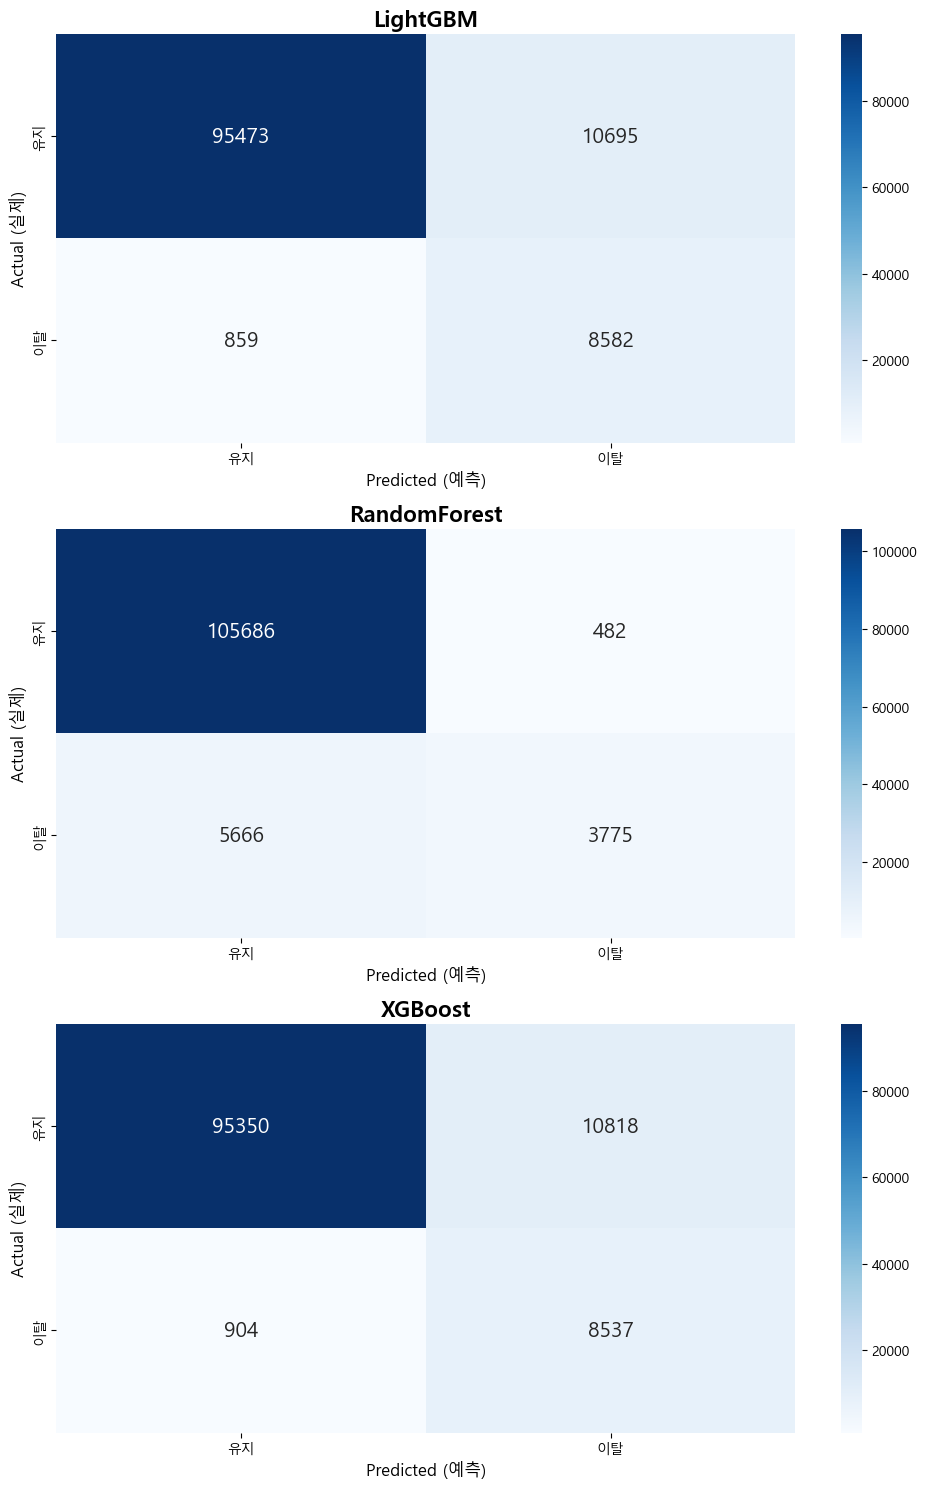

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# 한글 폰트 설정 (깨짐 방지)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 결과 리스트 취합
# (만약 에러가 난 모델이 있어 변수가 없다면 그 부분은 제외하고 리스트를 만드세요)
results_list = [res_lgbm, res_rf, res_xgb]

# -------------------------------------------------------
# [Part 1] 성능 지표 비교표 생성 (Accuracy, Recall 등)
# -------------------------------------------------------
metrics_data = []

for res in results_list:
    if res is not None:
        # Accuracy는 기존 딕셔너리에 없으므로 y_test와 y_pred로 즉석 계산
        acc = accuracy_score(y_test, res['y_pred'])
        
        metrics_data.append({
            'Model': res['model_name'],
            'Recall (재현율)': res['recall'],     # 실제 이탈자를 이탈로 맞춘 비율 (핵심)
            'Accuracy (정확도)': acc,            # 전체 정답률
            'AUC Score': res['auc'],             # 랭킹 변별력
            'F1-Score': res['f1']                # 정밀도와 재현율의 조화평균
        })

# DataFrame으로 깔끔하게 출력
df_metrics = pd.DataFrame(metrics_data).set_index('Model')
print("\n🏆 3대 모델 성능 비교표")
print("="*60)
print(df_metrics)
print("="*60)

# 시각화 (막대 그래프) - Recall과 Accuracy 비교
df_metrics[['Recall (재현율)', 'Accuracy (정확도)']].plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("모델별 Recall vs Accuracy 비교")
plt.ylabel("Score")
plt.ylim(0, 1.1) # 0~1 사이 범위 고정
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# -------------------------------------------------------
# [Part 2] 혼동행렬(Confusion Matrix) 3개 나란히 그리기
# -------------------------------------------------------
print("\n🔍 모델별 혼동행렬 (Confusion Matrix) 비교")

# 1행 3열의 서브플롯 생성
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

for i, res in enumerate(results_list):
    if res is not None:
        # 혼동행렬 계산
        cm = confusion_matrix(y_test, res['y_pred'])
        
        # 히트맵 그리기
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={"size": 15})
        
        # 타이틀 및 레이블 설정
        axes[i].set_title(f"{res['model_name']}", fontsize=16, fontweight='bold')
        axes[i].set_xlabel("Predicted (예측)", fontsize=12)
        axes[i].set_ylabel("Actual (실제)", fontsize=12)
        axes[i].set_xticklabels(['유지', '이탈'])
        axes[i].set_yticklabels(['유지', '이탈'])

plt.tight_layout()
plt.show()
